In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

Declarar la ruta y la extención del dataset

In [2]:
import pathlib
data_dir = pathlib.Path('/home/nvidia/Desktop/letras_dataset/')
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

13500


Probar que se encuentren las imagenes

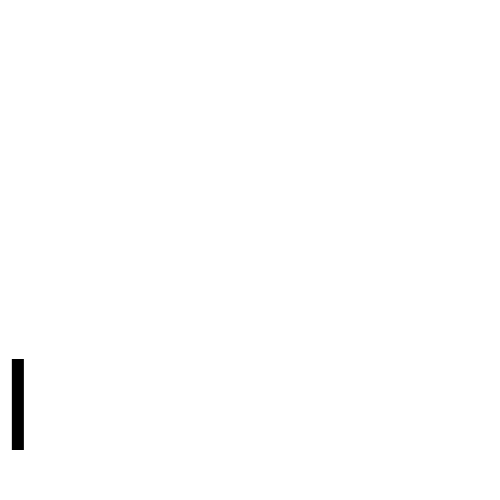

In [3]:
letras = list(data_dir.glob('I/*'))
PIL.Image.open(str(letras[0]))

Definir parametros de las imagenes que se van a cargar

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Definimos que el 20% de imagenes se utilicen para hacer la validacion

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13500 files belonging to 9 classes.
Using 10800 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13500 files belonging to 9 classes.
Using 2700 files for validation.


Verificar el nombre de las clases

In [ ]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']


Verificar el conjunto de imagenes con sus respectivas clases

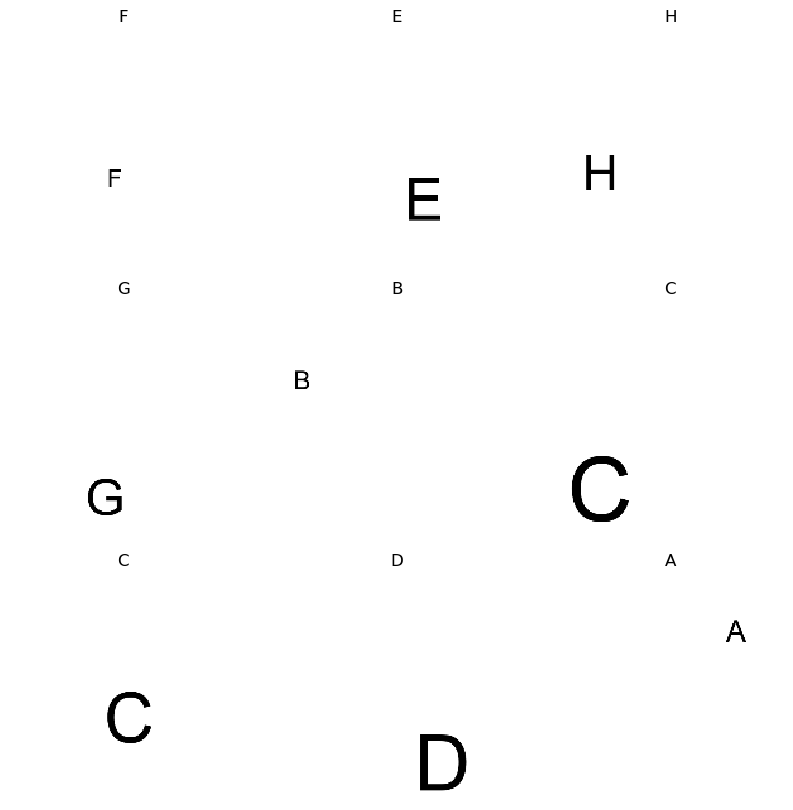

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


image_batch es un tensor de la forma (32, 180, 180, 3) . Este es un lote de 32 imágenes de forma 180x180x3 (la última dimensión se refiere a los canales de color RGB). El label_batch es un tensor de la forma (32,) , estas son las etiquetas correspondientes a las 32 imágenes.

Configurar el conjunto de datos para el rendimiento

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Estandarizar los datos
Los valores del canal RGB están en el rango [0, 255] . Esto no es ideal para una red neuronal; en general, debe buscar que sus valores de entrada sean pequeños.

In [74]:
normalization_layer = layers.Rescaling(1./255)

In [75]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
print(image_batch)
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
# get name clases with the index in the output


El modelo secuencial consta de tres bloques de convolución ( tf.keras.layers.Conv2D ) con una capa de agrupación máxima ( tf.keras.layers.MaxPooling2D ) en cada uno de ellos. Hay una capa totalmente conectada ( tf.keras.layers.Dense ) con 128 unidades encima que se activa mediante una función de activación de ReLU ( 'relu' ). Este modelo no se ha ajustado para una alta precisión

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Vea todas las capas de la red utilizando el método Model.summary del modelo:

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# !pip freeze | grep tensorflow

Num GPUs Available:  1


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

Entrenar el modelo

In [ ]:
epochs=5
batch_size = 32
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_3' (type Sequential).
    
    Input 0 of layer "conv2d_9" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 180, 180, 3)
    
    Call arguments received by layer 'sequential_3' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 180, 180, 3), dtype=float32)
      • training=True
      • mask=None


Ver resultados de entrenamiento

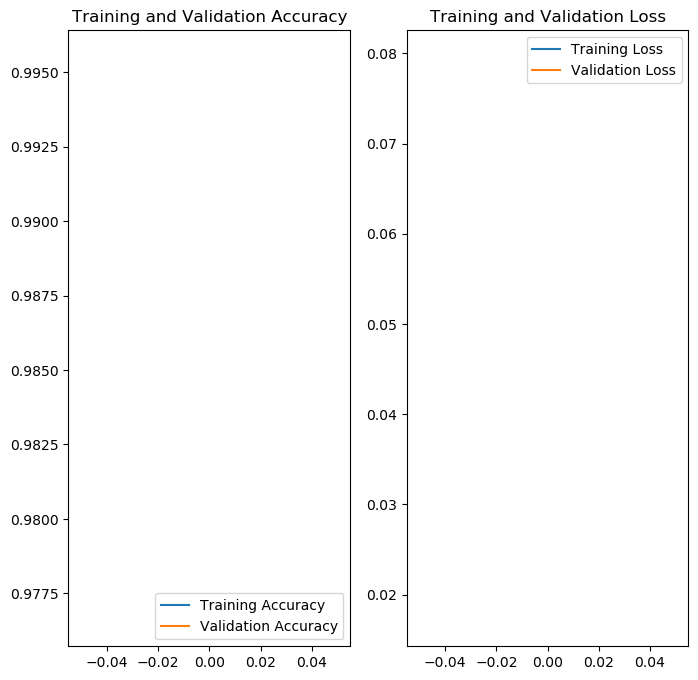

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Guardar el Modelo
model.save('model.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
new_model = keras.models.load_model('model.h5')